#This is my CE888 Project 2 building a CNN for Image Classification on the FLAME Dataset.

In [3]:
#import libraries 
import pandas as pd
import numpy as np
import os
import cv2
import glob
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input
from keras.layers import Dropout
from keras import models
from tensorflow.keras import Model
from keras import optimizers
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#unzip test file 
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Test.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

#unzip training file 
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Training.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done
done


In [6]:
#set batch size, image size 
batch_size = 32
img_height = 255
img_width = 255
train_dir = '/content/Training'
test_dir = '/content/Test'



In [7]:
#load images with flow from directory, set image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='binary',
                                              subset='training')

val_gen = val_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='binary',
                                              subset='validation')

test = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        shuffle=True,
                                                        class_mode='binary')

# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
# ])


Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [8]:
#load images into objects locally
train1 = tf.keras.preprocessing.image_dataset_from_directory(
     train_dir,
     labels='inferred',
     color_mode="rgb",
     batch_size=32,
     image_size= (img_height, img_width),
     shuffle=True,
     seed=123,
    validation_split=0.2,
     subset="training"
)

val1 = tf.keras.preprocessing.image_dataset_from_directory(
     train_dir,
     labels='inferred',
     color_mode="rgb",
     batch_size=32,
     image_size= (img_height, img_width),
     shuffle=True,
     seed=123,
    validation_split=0.2,
     subset="validation"
)

test1 = tf.keras.preprocessing.image_dataset_from_directory(
     test_dir,
     labels='inferred',
     color_mode="rgb",
     batch_size=32,
     image_size= (img_height, img_width),
     shuffle=True,
     seed=123
)

Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.
Found 8617 files belonging to 2 classes.


In [9]:
#view class names 
class_names = train1.class_names
print(class_names)

['Fire', 'No_Fire']


In [10]:
def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1) #change brightness lsightly by 0.1 delta 
    image = tf.image.random_flip_left_right(image) #randomly flip images left/right 50% of the time 
    image = tf.image.random_flip_up_down(image) #randomly flip images up/down 50% of the time
    return image, label

In [137]:
train1 = train1.map(augment)


In [ ]:
test1

<BatchDataset shapes: ((None, 255, 255, 3), (None,)), types: (tf.float32, tf.int32)>

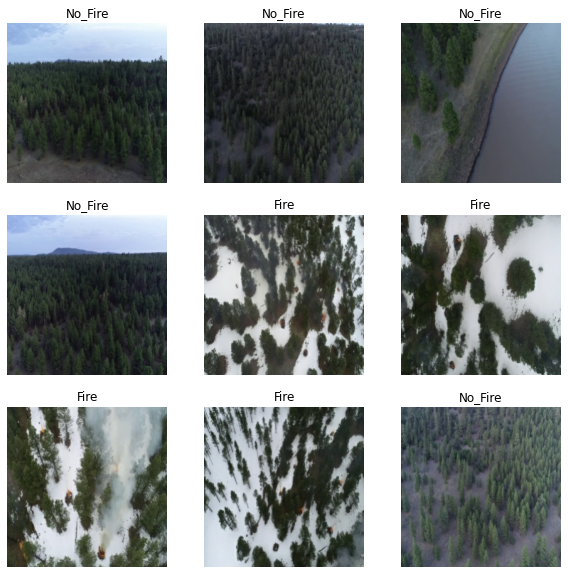

In [11]:
#visualise some example images from training set 
plt.figure(figsize=(10, 10))
for images, labels in train1.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
#check batch size, image shape 
for image_batch, labels_batch in train1:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 255, 255, 3)
(32,)


In [27]:
#load images in array form 
x_train = []
path = "/content/Training/No_Fire/*.jpg"
for file in glob.glob(path):
    a=cv2.imread(file)
    x_train.append(a)

y_train = []
path = "/content/Training/Fire/*.jpg"
for file in glob.glob(path):
    a=cv2.imread(file)
    y_train.append(a)

x_test = []
path = "/content/Test/No_Fire/*.jpg"
for file in glob.glob(path):
    a=cv2.imread(file)
    x_test.append(a)

y_test = []
path = "/content/Test/Fire/*.jpg"
for file in glob.glob(path):
    a=cv2.imread(file)
    y_test.append(a)

print('Training No Fire = ', len(x_train))
print('Training Fire = ', len(y_train))
print('Test No Fire = ', len(x_test))
print('Test Fire = ', len(y_test))

Training No Fire =  14357
Training Fire =  25018
Test No Fire =  3480
Test Fire =  5137


In [14]:
#create df for classes information on train/test set 
classes = pd.DataFrame({
    'Classes' : ['Training No Fire', 'Training Fire', 'Test No Fire', 'Test Fire'],
    'Total' : [len(x_train), len(y_train), len(x_test), len(y_test)]
})
classes

,Classes,Total
0,Training No Fire,14357
1,Training Fire,25018
2,Test No Fire,3480
3,Test Fire,5137


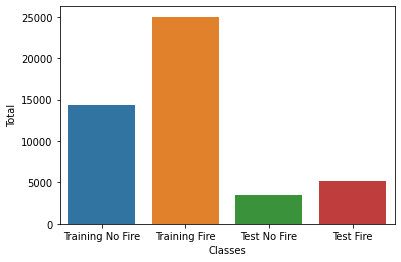

In [15]:
#barplot
sns.barplot(x= classes['Classes'], y=classes['Total'], data = classes)

In [28]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape) 
print(y_train.shape)

(14357, 254, 254, 3)
(25018, 254, 254, 3)


In [26]:
y_train = np.random.choice(y_train.shape[0], size=14357, replace=False)


TypeError: ignored

In [25]:
print(x_train.shape) 
print(y_train.shape)

(14357, 254, 254, 3)
(14357,)


In [29]:
x_train = x_train.reshape(14357,3*254*254)
y_train = y_train.reshape(25018,3*254*254)

In [ ]:
#Over sample the minority class using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

x_sm, y_sm = sm.fit_resample(x_train, y_train)

print(f'''Shape of x before SMOTE: {x_train.shape}
      Shape of x after SMOTE: {x_sm.shape}''')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# #Rescale images between 0-1 for model to aid learning 
# normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train = train.cache().prefetch(buffer_size=AUTOTUNE)

In [138]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(255,255,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2))),
model.add(layers.Conv2D(64, (3,3), activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2,2))),
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)      

In [139]:
train1

<MapDataset shapes: ((None, 255, 255, 3), (None,)), types: (tf.float32, tf.int32)>

In [143]:
history = model.fit(
  train1,
  validation_data=val1,
  epochs=5
)

Epoch 1/5
985/985 [==============================] - 284s 288ms/step - loss: 0.0558 - accuracy: 0.9831 - val_loss: 0.0226 - val_accuracy: 0.9923
Epoch 2/5
985/985 [==============================] - 289s 293ms/step - loss: 0.0444 - accuracy: 0.9864 - val_loss: 0.0340 - val_accuracy: 0.9906
Epoch 3/5
985/985 [==============================] - 278s 281ms/step - loss: 0.0319 - accuracy: 0.9894 - val_loss: 0.0249 - val_accuracy: 0.9916
Epoch 4/5
985/985 [==============================] - 271s 275ms/step - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.0136 - val_accuracy: 0.9947
Epoch 5/5
985/985 [==============================] - 291s 295ms/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 0.0144 - val_accuracy: 0.9953


In [144]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
model_results = model.evaluate(test1)
print("test loss, test acc:", model_results)

Evaluate on test data
270/270 [==============================] - 39s 140ms/step - loss: 3.1084 - accuracy: 0.6089
test loss, test acc: [3.1083648204803467, 0.6089125871658325]


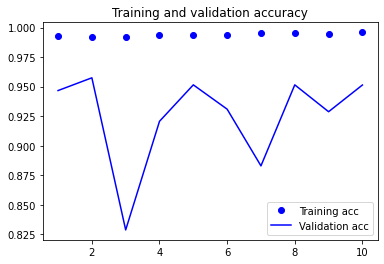

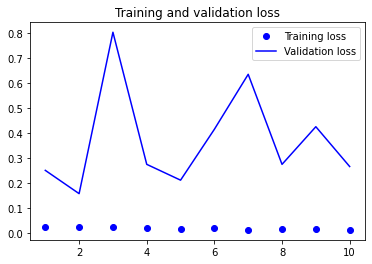

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## I will now import the pretrained RESnet50 CNN and use call backs and transfer learning to retrain the weights on the output layer for this specific task.

In [ ]:
#import and resize images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,
                                   brightness_range=[0.8,1.0],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_resize = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='binary',
                                              subset='training')

val_resize = val_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='binary',
                                              subset='validation')

test_resize = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        shuffle=True,
                                                        class_mode='binary')

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [ ]:
#set size etc 
IMG_SIZE = 224
LR = 1e-4
img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
#import and compile model 
Model.ResNet50 = tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=img_input,
    input_shape=None, pooling=None, classes=1000
)


Model.ResNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
last_layer = Model.ResNet50.get_layer('avg_pool').output
out = Dense(1, activation='sigmoid', name='output')(last_layer)  ## 2 classes
Model.ResNet50 = Model(img_input, out)

for layer in Model.ResNet50.layers[:-3]:
	layer.trainable = False

for i, layer in enumerate(Model.ResNet50.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [ ]:
# # mark some layers as trainable
# Model.ResNet50.get_layer('conv5_block3_out').trainable = True
# # model.get_layer('block1_conv2').trainable = True 
# # model.get_layer('block2_conv1').trainable = True 
# # model.get_layer('block2_conv2').trainable = True 

# for i, layer in enumerate(Model.ResNet50.layers):
#   print(i, layer.name, "-", layer.trainable)

In [ ]:
Model.ResNet50.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

from tensorflow.keras.callbacks import EarlyStopping
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
]


Model.ResNet50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = Model.ResNet50.fit(
  train_resize,
  validation_data=val_resize,
  epochs=1
)

985/985 [==============================] - 459s 462ms/step - loss: 0.2143 - acc: 0.9204 - val_loss: 0.0611 - val_acc: 0.9971


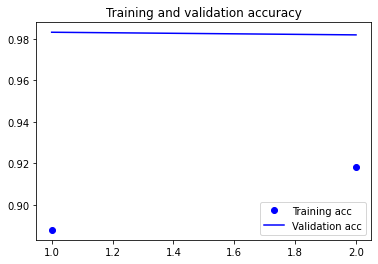

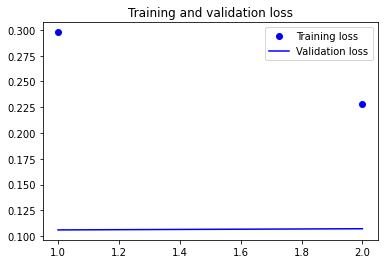

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
ResNet50_results = model.ResNet50.evaluate(test_resize)
print("test loss, test acc:", ResNet50_results)

Evaluate on test data
270/270 [==============================] - 22s 81ms/step - loss: 0.9477 - acc: 0.6290
test loss, test acc: [0.9476740956306458, 0.6289892196655273]


## I will now import the pretained ResNet101V2, I will reatrian the output layer to this task. 

In [ ]:
#import model
Model.ResNet101V2 = tf.keras.applications.ResNet101V2(
    include_top=True, weights='imagenet', input_tensor=img_input,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

Model.ResNet101V2.summary()

ResourceExhaustedError: ignored

In [ ]:
last_layer = Model.ResNet101V2.get_layer('avg_pool').output
out = Dense(1, activation='sigmoid', name='output')(last_layer)  ## 2 classes
Model.ResNet101V2 = Model(img_input, out)

for layer in Model.ResNet101V2_A.layers[:-1]:
	layer.trainable = False

for i, layer in enumerate(Model.ResNet101V2.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_9 - False
1 conv1_pad - False
2 conv1_conv - False
3 pool1_pad - False
4 pool1_pool - False
5 conv2_block1_preact_bn - False
6 conv2_block1_preact_relu - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_pad - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_out - False
17 conv2_block2_preact_bn - False
18 conv2_block2_preact_relu - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_pad - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_out - False
28 conv2_block3_preact_bn - False
29 conv2_block3_preact_relu - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_pad - False
3

In [ ]:
Model.ResNet101V2.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

from tensorflow.keras.callbacks import EarlyStopping
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]


Model.ResNet101V2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = model.ResNet101V2.fit(
  train_resize,
  validation_data=val_resize,
  epochs=3
)

Epoch 1/3
174/985 [====>.........................] - ETA: 4:30 - loss: 0.1681 - acc: 0.9404

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
ResNet101v2_results = Model.ResNet101V2_A.evaluate(test_resize)
print("test loss, test acc:", ResNet101V2_results)

Evaluate on test data
270/270 [==============================] - 24s 89ms/step - loss: 1.5442 - acc: 0.6806
test loss, test acc: [1.5442204475402832, 0.6806313395500183]


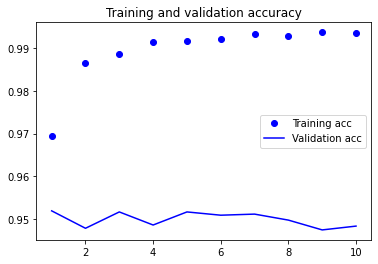

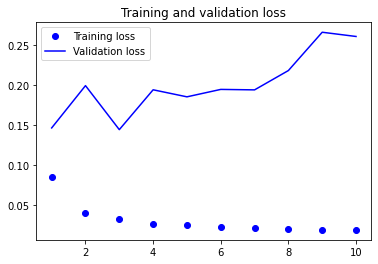

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## I will now use the VGG16 model on the dataset and use call backs and transfer learning to retrain the weights on the output layer 

In [ ]:
model_vgg16 = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax")

model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
last_layer = model_vgg16.get_layer('fc2').output
out = Dense(1, activation='sigmoid', name='output')(last_layer)  ## 2 classes
model_vgg16 = Model(img_input, out)

for layer in model_vgg16.layers[:-7]:
	layer.trainable = False

model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
for i, layer in enumerate(model_vgg16.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - True
17 block5_conv3 - True
18 block5_pool - True
19 flatten - True
20 fc1 - True
21 fc2 - True
22 output - True


In [ ]:
model_vgg16.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

from tensorflow.keras.callbacks import EarlyStopping
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]



In [ ]:
history = model_vgg16.fit(train_resize,
                               batch_size=28,
                               epochs=1, 
                               validation_data=val_resize,
                               callbacks=my_callbacks)

985/985 [==============================] - 442s 448ms/step - loss: 0.7857 - acc: 0.9109 - val_loss: 0.0473 - val_acc: 0.9902


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
vgg16_results = model_vgg16.evaluate(test_resize)
print("test loss, test acc:", vgg16_results)

Evaluate on test data
270/270 [==============================] - 21s 77ms/step - loss: 1.8384 - acc: 0.7375
test loss, test acc: [1.838438630104065, 0.7374956607818604]


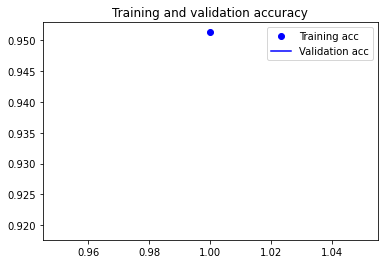

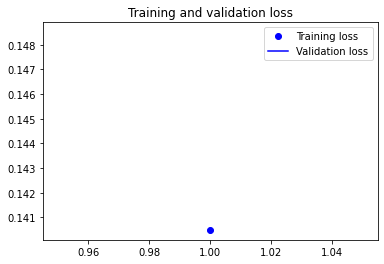

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:

#Create table of accuracies 
model_comparison = pd.DataFrame({
    'Model' : ['custom', 'ResNet50', 'VGG16'],
    'Score' : [model_results[1], ResNet50_results[1], vgg16_results[1]]
})
Model_comparison_df = model_comparison.sort_values(by='Score', ascending=False)
Model_comparison_df = Model_comparison_df.set_index('Score')
Model_comparison_df.reset_index()

,Score,Model
0,0.737496,VGG16
1,0.628989,ResNet50
2,0.585006,custom


In [ ]:
conv_model = VGG16(weights='imagenet', include_top=True)

In [ ]:
last_layer = conv_model.get_layer('block5_conv2').output
x = keras.layers.Dropout(0.5)(last_layer)

# creating the full model:
full_model = keras.models.Model(inputs=img_input, outputs=x)
full_model.summary()

ValueError: ignored

In [ ]:
for layer in full_model.layers[:-4]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(full_model.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False
19 flatten - False
20 fc1 - False
21 fc2 - False
22 dropout_30 - True
23 dense_85 - True


In [ ]:
full_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])


In [ ]:
history = full_model.fit(
    train_resize, 
    validation_data = val_resize,
    workers=10,
    epochs=1,
)

109/985 [==>...........................] - ETA: 3:56 - loss: 0.3939 - acc: 0.3599

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
vgg1_results = full_model.evaluate(test_resize)
print("test loss, test acc:", vgg1_results)

Evaluate on test data
270/270 [==============================] - 21s 78ms/step - loss: 1.0804 - acc: 0.4039
test loss, test acc: [1.0804224014282227, 0.4038528501987457]
